In [116]:
%matplotlib notebook
import cvxpy as cp
import dccp
import torch
import numpy as np
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.metrics import zero_one_loss, confusion_matrix
from scipy.io import arff
import pandas as pd
import time
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_classification
import matplotlib.patches as mpatches
import json

torch.set_default_dtype(torch.float64)
XDIM = 2
COST = 5
SLOPE_C = 1
X_LOWER_BOUND = -10
X_UPPER_BOUND = 10

# Datasets

In [117]:
def gen_data_case1():
    posX = torch.arange(-0.5, 2, 0.02)
    posX = torch.transpose(torch.stack((posX, torch.zeros(len(posX)))), 0, 1)
    negX = torch.arange(0.5, 3, 0.02)
    negX = torch.transpose(torch.stack((torch.zeros(len(negX)), negX)), 0, 1)

    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.ones(len(posX)), -torch.ones(len(negX))), 0), 1)

    X, Y = shuffle(X, Y)
    return X, Y

def gen_data_case2(N, pos_ranges, neg_ranges):
    """
    pos_ranges: a tuple of tensors of length XDIM.
    (scales tensor, offsets tensor)
    """
    pos_samples_num = N//2
    neg_samples_num = N - pos_samples_num
    posX = torch.rand((pos_samples_num, XDIM))*pos_ranges[0] + pos_ranges[1]
    negX = torch.rand((neg_samples_num, XDIM))*neg_ranges[0] + neg_ranges[1]
    
    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.ones(len(posX)), -torch.ones(len(negX))), 0), 1)

    X, Y = shuffle(X, Y)
    return X, Y


def load_spam_dataset():
    path = r"C:\Users\sagil\Desktop\nir project\tip_spam_data\IS_journal_tip_spam.arff"
    data, meta = arff.loadarff(path)
    df = pd.DataFrame(data)
    most_disc = ['qTips_plc', 'rating_plc', 'qEmail_tip', 'qContacts_tip', 'qURL_tip', 'qPhone_tip', 'qNumeriChar_tip', 'sentistrength_tip', 'combined_tip', 'qWords_tip', 'followers_followees_gph', 'qunigram_avg_tip', 'qTips_usr', 'indeg_gph', 'qCapitalChar_tip', 'class1']
    df = df[most_disc]
    df["class1"].replace({b'spam': -1, b'notspam': 1}, inplace=True)
    df = df.sample(frac=1).reset_index(drop=True)

    Y = df['class1'].values
    X = df.drop('class1', axis = 1).values
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    return torch.from_numpy(X), torch.from_numpy(Y)

def gen_data(N, informative_frac=1, shift_range=1, scale_range=1, noise_frac=0.01, seed=None):
    
    np.random.seed(seed)
    n_informative = int(informative_frac*XDIM)
    n_redundant = XDIM - n_informative
    shift_arr = shift_range*np.random.randn(XDIM)
    scale_arr = scale_range*np.random.randn(XDIM)
    X, Y = make_classification(n_samples=N, n_features=XDIM, n_informative=n_informative, n_redundant=n_redundant,
                               flip_y=noise_frac, shift=shift_arr, scale=scale_arr, random_state=seed)
    Y[Y == 0] = -1
    return torch.from_numpy(X), torch.from_numpy(Y)

# Utils

In [118]:
def split_data(X, Y, percentage):
    num_val = int(len(X)*percentage)
    return X[num_val:], Y[num_val:], X[:num_val], Y[:num_val]

def shuffle(X, Y):
    data = torch.cat((X, Y), 1)
    data = data[torch.randperm(data.size()[0])]
    X = data[:, :2]
    Y = data[:, 2]
    return X, Y

def conf_mat(Y1, Y2):
    num_of_samples = len(Y1)
    mat = confusion_matrix(Y1, Y2, labels=[-1, 1])*100/num_of_samples
    acc = np.trace(mat)
    return mat, acc

def pred(X, w, b):
    return torch.sign(score(X, w, b))

def calc_accuracy(Y, Ypred):
    num = len(Y)
    temp = Y - Ypred
    acc = len(temp[temp == 0])*1./num
    return acc

def evaluate_model(X, Y, w, b, v, ccp, strategic):
    if not strategic:
        Xopt = X
    else:
        Xopt = ccp.optimize_X(X, w, b, v)
    Ypred = pred(Xopt, w, b)
    return calc_accuracy(Y, Ypred)

# Visualization

In [119]:
def visualize_weights(w1, b1, w2, b2):
    fig = plt.figure()
    plt.bar(np.arange(XDIM + 1), np.append(w1, b1), color='b', alpha=0.5)
    plt.bar(np.arange(XDIM + 1), np.append(w2, b2), color='r', alpha=0.5)
    plt.show()
    
def visualize_data3D(X, Y):
    if not XDIM == 3:
        return
    
    Xpos = X[Y == 1]
    Xneg = X[Y == -1]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Xpos[:, 0], Xpos[:, 1], Xpos[:, 2], marker='+', color='green')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], Xneg[:, 2], marker='_', color='purple')
    plt.show()
    
def visualize_data2D(X, Y):
    if not XDIM == 2:
        return
    
    Xpos = X[Y == 1]
    Xneg = X[Y == -1]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='green')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='purple')
    
#     ax.set_title('Fixed VS adversary cost experiment dataset')
#     plt.savefig('plots/fixed_cost_VS_adversary_cost_dataset.pdf', format='pdf')
#     plt.savefig('plots/fixed_cost_VS_adversary_cost_dataset.eps', format='eps')
#     plt.savefig('plots/fixed_cost_VS_adversary_cost_dataset.png', format='png')
    
    plt.show()
    
def visualize_data(X, Y):
    if XDIM == 2:
        visualize_data2D(X, Y)
    else:
        visualize_data3D(X, Y)
    
def visualize_strategic_data3D(Xval, Xval_opt_fixed, Xval_opt_flexible, Yval,w_non_strategic, b_non_strategic, w_fixed, b_fixed, w_flexible, b_flexible):
    if not XDIM == 3:
        return

    Xpos = Xval[Yval == 1]
    Xneg = Xval[Yval == -1]
    XposOptFixed = Xval_opt_fixed[Yval == 1]
    XnegOptFixed = Xval_opt_fixed[Yval == -1]
    XposOptFlex = Xval_opt_flexible[Yval == 1]
    XnegOptFlex = Xval_opt_flexible[Yval == -1]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(Xpos[:, 0], Xpos[:, 1], Xpos[:, 2], marker='+', color='blue')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], Xneg[:, 2], marker='_', color='blue')

    ax.scatter(XposOptFixed[:, 0], XposOptFixed[:, 1], XposOptFixed[:, 2], marker='+', color='red')
    ax.scatter(XnegOptFixed[:, 0], XnegOptFixed[:, 1], XnegOptFixed[:, 2], marker='_', color='red')

    ax.scatter(XposOptFlex[:, 0], XposOptFlex[:, 1], XposOptFlex[:, 2], marker='+', color='green')
    ax.scatter(XnegOptFlex[:, 0], XnegOptFlex[:, 1], XnegOptFlex[:, 2], marker='_', color='green')

    range_arr = torch.arange(-2, 2 + 1)
    xx, yy = torch.meshgrid(range_arr, range_arr)
    z = (-w_non_strategic[0] * xx - w_non_strategic[1] * yy - b_non_strategic) * 1. /w_non_strategic[2]
    ax.plot_surface(xx.numpy(), yy.numpy(), z.numpy(), alpha=0.2, color='blue')

    xx, yy = torch.meshgrid(range_arr, range_arr)
    z = (-w_fixed[0] * xx - w_fixed[1] * yy - b_fixed) * 1. /w_fixed[2]
    ax.plot_surface(xx.numpy(), yy.numpy(), z.numpy(), alpha=0.2, color='red')
    
    xx, yy = torch.meshgrid(range_arr, range_arr)
    z = (-w_flexible[0] * xx - w_flexible[1] * yy - b_flexible) * 1. /w_flexible[2]
    ax.plot_surface(xx.numpy(), yy.numpy(), z.numpy(), alpha=0.2, color='red')
    
#     ax.set_xlim3d(-1.2, 1.2)
#     ax.set_ylim3d(-1.2, 1.2)
#     ax.set_zlim3d(-1.2, 1.2)
#     ax.view_init(25, 45)
#     plt.savefig('plots/simple_strategic_classification.pdf', format='pdf')
#     plt.savefig('plots/simple_strategic_classification.eps', format='eps')
#     plt.savefig('plots/simple_strategic_classification.png', format='png')

#     plt.xlim(-2, 2)
#     plt.ylim(-2, 2)
#     ax.set_zlim(-2,2)
    plt.show()

def visualize_strategic_data2D(Xval, Xval_opt_fixed, Xval_opt_flexible, Yval,w_non_strategic, b_non_strategic, w_fixed, b_fixed, w_flexible, b_flexible):
    if not XDIM == 2:
        return

    Xpos = Xval[Yval == 1]
    Xneg = Xval[Yval == -1]
    XposOptFixed = Xval_opt_fixed[Yval == 1]
    XnegOptFixed = Xval_opt_fixed[Yval == -1]
    XposOptFlex = Xval_opt_flexible[Yval == 1]
    XnegOptFlex = Xval_opt_flexible[Yval == -1]

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='blue')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='blue')

    ax.scatter(XposOptFixed[:, 0], XposOptFixed[:, 1], marker='+', color='red')
    ax.scatter(XnegOptFixed[:, 0], XnegOptFixed[:, 1], marker='_', color='red')
    
    ax.scatter(XposOptFlex[:, 0], XposOptFlex[:, 1], marker='+', color='green')
    ax.scatter(XnegOptFlex[:, 0], XnegOptFlex[:, 1], marker='_', color='green')

    range_arr = torch.arange(-8, 3 + 1)
    xx = torch.meshgrid(range_arr)[0]
    z = (-w_non_strategic[0] * xx - b_non_strategic) * 1. /w_non_strategic[1]
    ax.plot(xx.numpy(), z.numpy(), alpha=0.2, color='blue')

    xx = torch.meshgrid(range_arr)[0]
    z = (-w_fixed[0] * xx - b_fixed) * 1. /w_fixed[1]
    ax.plot(xx.numpy(), z.numpy(), alpha=0.2, color='red')
    
    xx = torch.meshgrid(range_arr)[0]
    z = (-w_flexible[0] * xx - b_flexible) * 1. /w_flexible[1]
    ax.plot(xx.numpy(), z.numpy(), alpha=0.2, color='green')
    
#     plt.savefig('plots/fixed_cost_VS_adversary_cost.pdf', format='pdf')
#     plt.savefig('plots/fixed_cost_VS_adversary_cost.eps', format='eps')
#     plt.savefig('plots/fixed_cost_VS_adversary_cost.png', format='png')
    
#     plt.show()
    
def visualize_strategic_data(Xval, Xval_opt_fixed, Xval_opt_flexible, Yval,w_non_strategic, b_non_strategic, w_fixed, b_fixed, w_flexible, b_flexible):
    if XDIM == 2:
        visualize_strategic_data2D(Xval, Xval_opt_fixed, Xval_opt_flexible, Yval,w_non_strategic, b_non_strategic, w_fixed, b_fixed, w_flexible, b_flexible)
    else:
        visualize_strategic_data3D(Xval, Xval_opt_fixed, Xval_opt_flexible, Yval,w_non_strategic, b_non_strategic, w_fixed, b_fixed, w_flexible, b_flexible)
        
def visualize_training_errors(train_errors, val_errors):
    fig = plt.figure()
    train_patch, = plt.plot(torch.arange(len(train_errors)), np.mean(train_errors, axis=1), color='blue', label="train")
    val_patch, = plt.plot(torch.arange(len(val_errors)), val_errors, color='orange', label="validation")
    plt.legend(handles=[train_patch, val_patch])

    plt.show()
    
def visualize_training_losses(train_losses, val_losses):
    fig = plt.figure()
    train_patch, = plt.plot(torch.arange(len(train_losses)), np.mean(train_losses, axis=1), color='blue', label="train")
    val_patch, = plt.plot(torch.arange(len(val_losses)), val_losses, color='orange', label="validation")
    plt.legend(handles=[train_patch, val_patch])
    
    plt.show()

# CCP classes

In [120]:
class CCP:
    def __init__(self, funcs):
        self.f_derivative = funcs["f_derivative"]
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(XDIM)
        self.xt = cp.Parameter(XDIM)
        self.r = cp.Parameter(XDIM)
        self.w = cp.Parameter(XDIM)
        self.b = cp.Parameter(1)
        self.v = cp.Parameter(XDIM) # vvv

        target = self.x@self.f_derivative(self.xt, self.w, self.b) - self.g(self.x, self.w, self.b) - self.c(self.x, self.r, cp.abs(self.v)) # vvv
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        self.prob = cp.Problem(cp.Maximize(target), constraints)
        
        print("problem is DCP:", self.prob.is_dcp())
        print("problem is DPP:", self.prob.is_dpp())
        
    def ccp(self, r):
        """
        numpy to numpy
        """
        self.xt.value = r
        self.r.value = r
        result = self.prob.solve()
        diff = np.linalg.norm(self.xt.value - self.x.value)
        while diff > 0.0001:
            self.xt.value = self.x.value
            result = self.prob.solve()
            diff = np.linalg.norm(self.x.value - self.xt.value)
        return self.x.value
    
    def optimize_X(self, X, w, b, v):
        """
        tensor to tensor
        """
        w = w.detach().numpy()
        b = b.detach().numpy()
        v = v.detach().numpy() # vvv
        X = X.numpy()
        
        self.w.value = w
        self.b.value = b
        self.v.value = v # vvv
        
        return torch.stack([torch.from_numpy(self.ccp(x)) for x in X])

In [121]:
class DELTA():
    
    def __init__(self, funcs):
        self.g = funcs["g"]
        self.c = funcs["c_dpp_form"]
        
        self.x = cp.Variable(XDIM)
#         self.r = cp.Parameter(XDIM, value = np.random.randn(XDIM))
        self.w = cp.Parameter(XDIM, value = np.random.randn(XDIM))
        self.b = cp.Parameter(1, value = np.random.randn(1))
        self.v = cp.Parameter(XDIM, value = np.random.rand(XDIM), nonneg=True) # vvv
        self.rv = cp.Parameter(XDIM, value = np.random.randn(XDIM)) # r times v
        self.r2v = cp.Parameter(XDIM, value = np.random.randn(XDIM)) # r squared times v
        self.f_der = cp.Parameter(XDIM, value = np.random.randn(XDIM))

        target = self.x@self.f_der - self.g(self.x, self.w, self.b) - self.c(self.x, self.rv, self.r2v)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        objective = cp.Maximize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.f_der, self.w, self.b, self.rv, self.r2v], variables=[self.x]) # vvv
        
    def optimize_X(self, X, F_DER, w, b, v):
        rv = X*v
        r2v = (X**2)*v
        return self.layer(F_DER, w, b, rv, r2v)[0]
    

# Gain & Cost functions

In [122]:
def score(x, w, b):
    return x@w + b

def f(x, w, b):
    return 0.5*cp.norm(cp.hstack([1, (SLOPE_C*score(x, w, b) + 1)]), 2)

def g(x, w, b):
    return 0.5*cp.norm(cp.hstack([1, (SLOPE_C*score(x, w, b) - 1)]), 2)

def c(x, r, v): # vvv
    return COST*cp.abs(cp.multiply(x, r) - cp.square(r))@v     # COST*(cp.pos(cp.square(x)-cp.multiply(x, r)))@v    # COST*cp.square(x-r)@v

def c_dpp_form(x, rv, r2v):
    return COST*cp.sum(cp.abs(cp.multiply(x, rv) - r2v))                       # COST*cp.sum(cp.pos(cp.multiply(cp.square(x), v) - cp.multiply(rv, x)))     # COST*cp.sum(cp.multiply(cp.square(x), v) - 2*cp.multiply(x, rv) + r2v)

def f_derivative(x, w, b):
    return 0.5*SLOPE_C*((SLOPE_C*score(x, w, b) + 1)/cp.sqrt((SLOPE_C*score(x, w, b) + 1)**2 + 1))*w

def g_derivative(x, w, b):
    return 0.5*SLOPE_C*((SLOPE_C*score(x, w, b) - 1)/cp.sqrt((SLOPE_C*score(x, w, b) - 1)**2 + 1))*w

funcs = {"f": f, "g": g, "f_derivative": f_derivative, "g_derivative": g_derivative,
         "c": c, "c_dpp_form": c_dpp_form, "score": score}

# Data generation

<IPython.core.display.Javascript object>


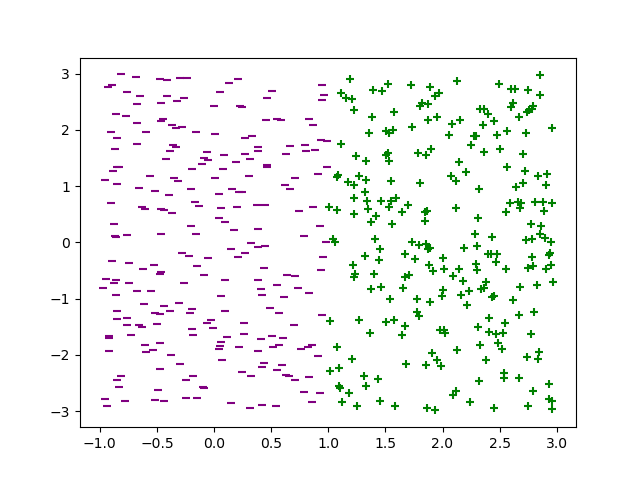

percent of positive samples: 50.0%


In [123]:
N = 500
# X, Y = gen_data(N, informative_frac=1, seed=111)
# X, Y = load_spam_dataset()
X, Y = gen_data_case2(N, (torch.Tensor([2, 6]), torch.Tensor([1, -3])), (torch.Tensor([2, 6]), torch.Tensor([-1, -3])))

assert(len(X[0]) == XDIM)
# X, Y, Xval, Yval = split_data(X, Y, 0.25)
Xval, Yval = X, Y
visualize_data(X, Y)
print("percent of positive samples: {}%".format(100 * len(Y[Y == 1]) / len(Y)))

# Train

In [124]:
def fit(evaluate, loss, params, X, Y, Xval, Yval, opt, opt_kwargs={"lr":1e-3}, batch_size=128, epochs=100, verbose=False, callback=None, calc_train_errors=False):
    
    train_dset = TensorDataset(X, Y)
    train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
    
    if len(params) == 3:
        opt = opt(params[0:2], **opt_kwargs)
        opt2 = torch.optim.Adam(params[2:3], **opt_kwargs)
    
    else:
        opt = opt(params, **opt_kwargs)

    train_losses = []
    val_losses = []
    train_errors = []
    val_errors = []
    
    total_time = time.time()
    for epoch in range(epochs):
        t1 = time.time()
        
        batch = 1
        train_losses.append([])
        train_errors.append([])
        for Xbatch, Ybatch in train_loader:
            if len(params) == 3:
                opt2.zero_grad()
                l2 = loss(Xbatch, Ybatch, True)
                l2.backward()
                opt2.step()
            opt.zero_grad()
            l = loss(Xbatch, Ybatch, False)
            l.backward()
            opt.step()
            
            train_losses[-1].append(l.item())
            if calc_train_errors:
                with torch.no_grad():
                    e = evaluate(Xbatch, Ybatch)
                    train_errors[-1].append(1-e)
                if verbose:
                    print("batch %03d / %03d | loss: %3.5f | err: %3.5f" % 
                          (batch, len(train_loader), np.mean(train_losses[-1]), np.mean(train_errors[-1])))
            else:
                if verbose:
                    print("batch %03d / %03d | loss: %3.5f" %
                          (batch, len(train_loader), np.mean(train_losses[-1])))
            batch += 1
            if callback is not None:
                callback()
                
#         with torch.no_grad():
#             val_losses.append(loss(Xval, Yval).item())
#             val_errors.append(1-evaluate(Xval, Yval))
            
        t2 = time.time()
#         if verbose:
#             print("----- epoch %03d / %03d | time: %03d sec | loss: %3.5f | err: %3.5f" % (epoch + 1, epochs, t2-t1, val_losses[-1], val_errors[-1]))
    print("training time: {} seconds".format(time.time()-total_time)) 
    return train_errors, val_errors, train_losses, val_losses


def get_f_ders(XT, w, b):
    """
    tensor to tensor
    """
    return torch.stack([0.5*SLOPE_C*((SLOPE_C*score(xt, w, b) + 1)/torch.sqrt((SLOPE_C*score(xt, w, b) + 1)**2 + 1))*w for xt in XT])


In [125]:
ccp = CCP(funcs)
delta = DELTA(funcs)
v_true = torch.ones(XDIM, requires_grad=False) # torch.rand(XDIM, requires_grad=False) + 0.5

def loss(X, Y, w, b, v, lam, strategic=True, adversary_loss=False): # vvv
    if strategic:
        v = torch.abs(v)
        XT = ccp.optimize_X(X, w, b, v) # vvv
        F_DER = get_f_ders(XT, w, b)
        Xopt = delta.optimize_X(X, F_DER, w, b, v)
        output = score(Xopt, w, b)
        if adversary_loss:
            loss = -torch.mean(torch.clamp(1 - output * Y, min=0)) + lam*torch.abs(torch.sum(v_true)-torch.sum(v))
        else:
            loss = torch.mean(torch.clamp(1 - output * Y, min=0)) # lam*torch.abs(torch.sum(v_true)-torch.sum(v))
    else:
        output = score(X, w, b)
        loss = torch.mean(torch.clamp(1 - output * Y, min=0))
    
    return loss

problem is DCP: True
problem is DPP: False


In [126]:
EPOCHS = 10
BATCH_SIZE = 32
LAMBDA = 0.1

# non-strategic classification
print("---------- training non-strategically----------")
w_non_strategic = torch.zeros(XDIM, requires_grad=True)
b_non_strategic = torch.zeros(1, requires_grad=True)
v_non_strategic = torch.zeros(XDIM, requires_grad=True)

fit_res_non_strategic = fit(lambda X, Y: evaluate_model(X, Y, w_non_strategic, b_non_strategic, v_non_strategic, ccp, strategic=False), 
                               lambda X, Y, al: loss(X, Y, w_non_strategic, b_non_strategic, v_non_strategic, 0, strategic=False, adversary_loss=al),
                               [w_non_strategic, b_non_strategic], X, Y, Xval, Yval,
                               opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                               batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False)

w_non_strategic.requires_grad = False
b_non_strategic.requires_grad = False

# strategic classification with fixed v
print("---------- training strategically with fixed v----------")
w_fixed = torch.zeros(XDIM, requires_grad=True)
b_fixed = torch.zeros(1, requires_grad=True)
v_fixed = v_true

fit_res_fixed = fit(lambda X, Y: evaluate_model(X, Y, w_fixed, b_fixed, v_fixed, ccp, strategic=True), 
                               lambda X, Y, al: loss(X, Y, w_fixed, b_fixed, v_fixed, 0, strategic=True, adversary_loss=al), 
                               [w_fixed, b_fixed], X, Y, Xval, Yval,
                               opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                               batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False)

w_fixed.requires_grad = False
b_fixed.requires_grad = False

# strategic classification with flexible v
print("---------- training strategically with flexible v----------")
w_flexible = torch.zeros(XDIM, requires_grad=True)
b_flexible = torch.zeros(1, requires_grad=True)
v_flexible = torch.ones(XDIM, requires_grad=True)

fit_res_flexible = fit(lambda X, Y: evaluate_model(X, Y, w_flexible, b_flexible, v_flexible, ccp, strategic=True), 
                               lambda X, Y, al: loss(X, Y, w_flexible, b_flexible, v_flexible, LAMBDA, strategic=True, adversary_loss=al),
                               [w_flexible, b_flexible, v_flexible], X, Y, Xval, Yval,
                               opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                               batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False)

w_flexible.requires_grad = False
b_flexible.requires_grad = False
v_flexible.requires_grad = False

---------- training non-strategically----------
batch 001 / 016 | loss: 1.00000
batch 002 / 016 | loss: 0.95439
batch 003 / 016 | loss: 0.90613
batch 004 / 016 | loss: 0.83630
batch 005 / 016 | loss: 0.78645
batch 006 / 016 | loss: 0.73618
batch 007 / 016 | loss: 0.72820
batch 008 / 016 | loss: 0.72510
batch 009 / 016 | loss: 0.69983
batch 010 / 016 | loss: 0.66552
batch 011 / 016 | loss: 0.65870
batch 012 / 016 | loss: 0.63435
batch 013 / 016 | loss: 0.60456
batch 014 / 016 | loss: 0.57778
batch 015 / 016 | loss: 0.56130
batch 016 / 016 | loss: 0.53912
batch 001 / 016 | loss: 0.14292
batch 002 / 016 | loss: 0.16340
batch 003 / 016 | loss: 0.22877
batch 004 / 016 | loss: 0.20131
batch 005 / 016 | loss: 0.20622
batch 006 / 016 | loss: 0.19028
batch 007 / 016 | loss: 0.19751
batch 008 / 016 | loss: 0.19577
batch 009 / 016 | loss: 0.19821
batch 010 / 016 | loss: 0.19393
batch 011 / 016 | loss: 0.18587
batch 012 / 016 | loss: 0.18884
batch 013 / 016 | loss: 0.17976
batch 014 / 016 | loss: 

batch 013 / 016 | loss: 0.15565
batch 014 / 016 | loss: 0.15439
batch 015 / 016 | loss: 0.15453
batch 016 / 016 | loss: 0.15045
batch 001 / 016 | loss: 0.09120
batch 002 / 016 | loss: 0.08261
batch 003 / 016 | loss: 0.08222
batch 004 / 016 | loss: 0.10032
batch 005 / 016 | loss: 0.15913
batch 006 / 016 | loss: 0.16254
batch 007 / 016 | loss: 0.16086
batch 008 / 016 | loss: 0.14546
batch 009 / 016 | loss: 0.13378
batch 010 / 016 | loss: 0.13709
batch 011 / 016 | loss: 0.13588
batch 012 / 016 | loss: 0.14386
batch 013 / 016 | loss: 0.14160
batch 014 / 016 | loss: 0.14953
batch 015 / 016 | loss: 0.14397
batch 016 / 016 | loss: 0.13858
batch 001 / 016 | loss: 0.06716
batch 002 / 016 | loss: 0.20097
batch 003 / 016 | loss: 0.19747
batch 004 / 016 | loss: 0.16631
batch 005 / 016 | loss: 0.14637
batch 006 / 016 | loss: 0.13790
batch 007 / 016 | loss: 0.15982
batch 008 / 016 | loss: 0.15809
batch 009 / 016 | loss: 0.15314
batch 010 / 016 | loss: 0.14692
batch 011 / 016 | loss: 0.14771
batch 01

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\diffcp\cone_program.py:259: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


batch 013 / 016 | loss: 0.30592
batch 014 / 016 | loss: 0.29744
batch 015 / 016 | loss: 0.31022
batch 016 / 016 | loss: 0.30149
batch 001 / 016 | loss: 0.10756
batch 002 / 016 | loss: 0.22682
batch 003 / 016 | loss: 0.24348
batch 004 / 016 | loss: 0.23768
batch 005 / 016 | loss: 0.26014
batch 006 / 016 | loss: 0.29075
batch 007 / 016 | loss: 0.28542
batch 008 / 016 | loss: 0.30282
batch 009 / 016 | loss: 0.31506
batch 010 / 016 | loss: 0.30331
batch 011 / 016 | loss: 0.28023
batch 012 / 016 | loss: 0.27509
batch 013 / 016 | loss: 0.26224
batch 014 / 016 | loss: 0.26220
batch 015 / 016 | loss: 0.26132
batch 016 / 016 | loss: 0.28464
batch 001 / 016 | loss: 0.12320
batch 002 / 016 | loss: 0.23314
batch 003 / 016 | loss: 0.17572
batch 004 / 016 | loss: 0.20940
batch 005 / 016 | loss: 0.18881
batch 006 / 016 | loss: 0.19213
batch 007 / 016 | loss: 0.18127
batch 008 / 016 | loss: 0.18811
batch 009 / 016 | loss: 0.19651
batch 010 / 016 | loss: 0.20493
batch 011 / 016 | loss: 0.21510
batch 01

In [112]:
print("fixed:", v_fixed)
print("flexible:", v_flexible)
print("diff:", v_flexible-v_fixed)
print("diff norm:", torch.norm(v_fixed-v_flexible))

v_flexible = torch.abs(v_flexible)

fixed: tensor([1., 1.])
flexible: tensor([0.0043, 2.0083])
diff: tensor([-0.9957,  1.0083])
diff norm: tensor(1.4170)


# Test results

In [115]:
fixed_total = 0
flexible_total = 0

fixed_total_mat = np.zeros((2, 2))
flexible_total_mat = np.zeros((2, 2))
for i in range(30):
    v_rand = torch.abs(0.3*torch.randn(XDIM))
    print("round: {}, v_rand: {}".format(i, v_rand))
    Xval_opt_fixed = ccp.optimize_X(Xval[:100], w_fixed, b_fixed, v_rand)
    Xval_opt_flexible = ccp.optimize_X(Xval[:100], w_flexible, b_flexible, v_rand)

    FpXp_fixed = pred(Xval_opt_fixed, w_fixed, b_fixed)
    FpXp_flexible = pred(Xval_opt_flexible, w_flexible, b_flexible)
    
    fixed_mat, fixed_acc = conf_mat(Yval[:100], FpXp_fixed)
    flexible_mat, flexible_acc = conf_mat(Yval[:100], FpXp_flexible)
    fixed_total_mat += fixed_mat
    flexible_total_mat += flexible_mat
    fixed_total += fixed_acc
    flexible_total += flexible_acc
    
    print("fixed_total: {}, flexible_total: {}".format(fixed_total, flexible_total))


round: 0, v_rand: tensor([0.3498, 0.0118])
fixed_total: 55.0, flexible_total: 55.0
round: 1, v_rand: tensor([0.1143, 0.3616])
fixed_total: 110.0, flexible_total: 93.0
round: 2, v_rand: tensor([0.0590, 0.0613])
fixed_total: 165.0, flexible_total: 148.0
round: 3, v_rand: tensor([0.1280, 0.1019])
fixed_total: 220.0, flexible_total: 196.0
round: 4, v_rand: tensor([0.2279, 0.2672])


KeyboardInterrupt: 

fixed acc: 
 74.1
flexible acc: 
 72.43333333333334
-----------------------
fixed mat: 
 [[27.6 19.4]
 [ 6.5 46.5]]
flexible mat: 
 [[27.46666667 19.53333333]
 [ 8.03333333 44.96666667]]
-----------------------
non-strategic: y vs f(x):
[[27. 20.]
 [22. 31.]]
accuracy: 58.0
fixed: y vs f'(x'):
[[24. 23.]
 [ 3. 50.]]
accuracy: 74.0
flexible: y vs f'(x'):
[[35. 12.]
 [ 3. 50.]]
accuracy: 85.0


<IPython.core.display.Javascript object>


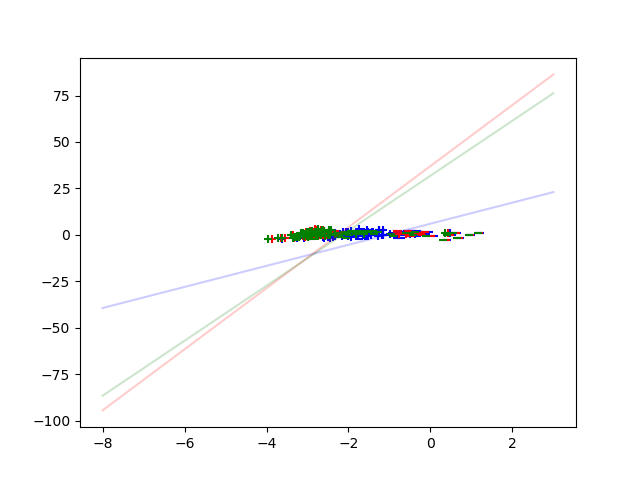

In [100]:
print("fixed acc: \n",fixed_total/30)
print("flexible acc: \n", flexible_total/30)
print("-----------------------")

print("fixed mat: \n", fixed_total_mat/30)
print("flexible mat: \n", flexible_total_mat/30)

print("-----------------------")

# data = {}
# data['X'] = X.numpy().tolist()
# data['Y'] = Y.numpy().tolist()
# data['Xval'] = Xval.numpy().tolist()
# data['Yval'] = Yval.numpy().tolist()
# data['w_fixed'] = w_fixed.numpy().tolist()
# data['w_fixed'] = b_fixed.numpy().tolist()
# data['w_flexible'] = w_flexible.numpy().tolist()
# data['b_flexible'] = b_flexible.numpy().tolist()
# data['v'] = v_flexible.numpy().tolist()
# data['info'] = "epochs:5, batch:24"

# with open('fixed_cost_VS_adversary_cost3.txt', 'w') as outfile:
#     json.dump(data, outfile)

print("non-strategic: y vs f(x):\n{}\naccuracy: {}".format(*conf_mat(Yval[:100], FX)))
print("fixed: y vs f\'(x\'):\n{}\naccuracy: {}".format(*conf_mat(Yval[:100], FpXp_fixed)))
print("flexible: y vs f\'(x\'):\n{}\naccuracy: {}".format(*conf_mat(Yval[:100], FpXp_flexible)))

visualize_strategic_data(Xval[:100], Xval_opt_fixed, Xval_opt_flexible, Yval[:100], w_non_strategic, b_non_strategic, w_fixed, b_fixed, w_flexible, b_flexible)